In [1]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import pywt  # PyWavelets for wavelet decomposition and reconstruction
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Reshape
from tensorflow.keras.models import Model

##### Define Wavelet Decomposition and Reconstruction Functions

In [3]:
def wavelet_decompose(signal, wavelet='db1', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

def wavelet_reconstruct(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet)

##### Prepare Data with Wavelet Decomposition

In [4]:
# Load your dataset (assuming CSV files as provided earlier)
X_train = pd.read_csv('Project datasets/Sample files/train_inputs_50.csv', header=None).values
y_train = pd.read_csv('Project datasets/Sample files/train_outputs_50.csv', header=None).values
X_test = pd.read_csv('Project datasets/Sample files/test_inputs_50.csv', header=None).values
y_test = pd.read_csv('Project datasets/Sample files/test_outputs_50.csv', header=None).values

# Perform wavelet decomposition on each spectrum (up to level 3)
def decompose_dataset(dataset, wavelet='db1', level=3):
    decomposed_data = [wavelet_decompose(spectrum.flatten(), wavelet, level) for spectrum in dataset]
    return decomposed_data

X_train_wavelet = decompose_dataset(X_train)
X_test_wavelet = decompose_dataset(X_test)
y_train_wavelet = decompose_dataset(y_train)
y_test_wavelet = decompose_dataset(y_test)

##### Flatten Decomposed Coefficients for Input to Autoencoder

In [5]:
def flatten_wavelet_coeffs(wavelet_data):
    return np.array([np.concatenate(coeff) for coeff in wavelet_data])

X_train_flat = flatten_wavelet_coeffs(X_train_wavelet)
X_test_flat = flatten_wavelet_coeffs(X_test_wavelet)
y_train_flat = flatten_wavelet_coeffs(y_train_wavelet)
y_test_flat = flatten_wavelet_coeffs(y_test_wavelet)

# Confirm data shapes
print("X_train_flat shape:", X_train_flat.shape)
print("y_train_flat shape:", y_train_flat.shape)


X_train_flat shape: (50, 501)
y_train_flat shape: (50, 501)


##### Define the Autoencoder Model

In [6]:
def build_autoencoder(input_dim):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Build and compile the model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.summary()
    return autoencoder

# Define and compile the model
input_dim = X_train_flat.shape[1]
wavelet_ae_model = build_autoencoder(input_dim)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 501)]             0         
                                                                 
 dense (Dense)               (None, 128)               64256     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 501)               64629 

##### Train the Model

Epoch 1/100
13/13 [==============================] - 5s 73ms/step - loss: 0.0011 - val_loss: 6.9522e-04
Epoch 2/100
13/13 [==============================] - 0s 25ms/step - loss: 3.8748e-04 - val_loss: 1.2961e-04
Epoch 3/100
13/13 [==============================] - 0s 17ms/step - loss: 2.3893e-04 - val_loss: 1.0561e-04
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 1.6824e-04 - val_loss: 6.5563e-05
Epoch 5/100
13/13 [==============================] - 0s 17ms/step - loss: 1.0995e-04 - val_loss: 6.7499e-05
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: 7.9764e-05 - val_loss: 5.4980e-05
Epoch 7/100
13/13 [==============================] - 0s 21ms/step - loss: 6.1962e-05 - val_loss: 6.1380e-05
Epoch 8/100
13/13 [==============================] - 0s 17ms/step - loss: 5.8488e-05 - val_loss: 8.0991e-05
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 6.0093e-05 - val_loss: 4.2093e-05
Epoch 10/100
13/13 [============

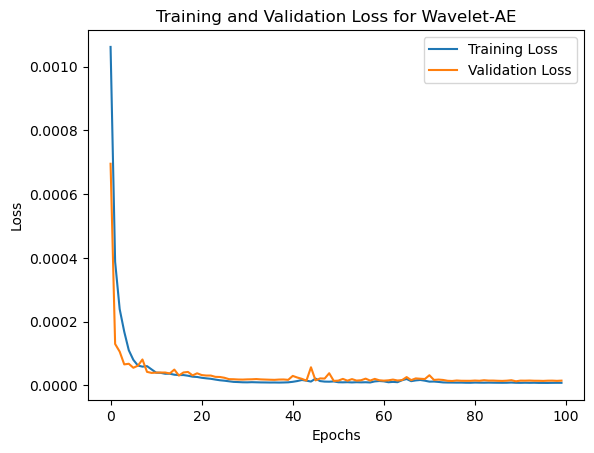

In [7]:
# Train the autoencoder
history = wavelet_ae_model.fit(X_train_flat, y_train_flat, epochs=100, batch_size=4, validation_data=(X_test_flat, y_test_flat))

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for Wavelet-AE')
plt.show()

##### Visualize the Results

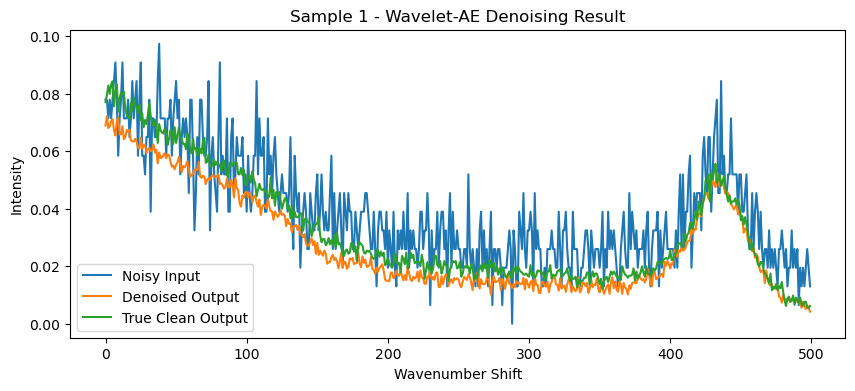

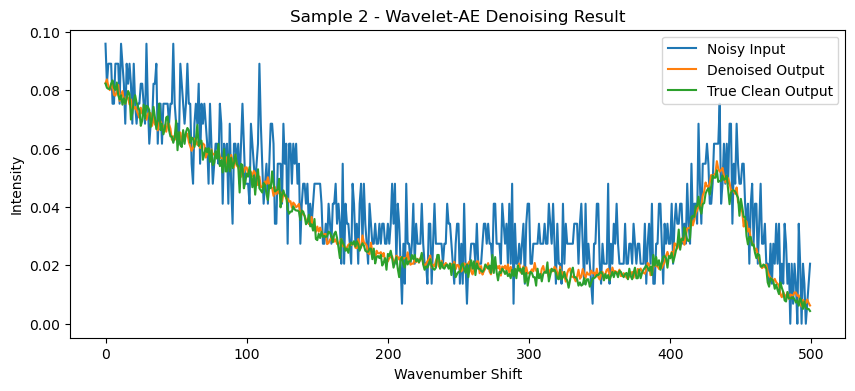

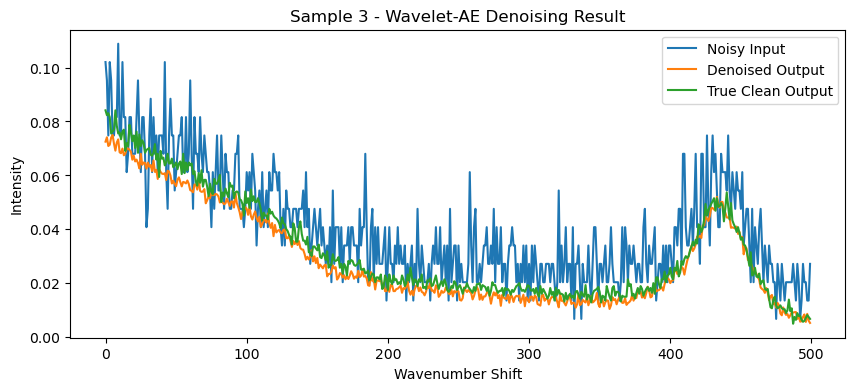

In [9]:
for i in range(3):  # Plot a few examples
    plt.figure(figsize=(10, 4))
    plt.plot(X_test[i].flatten(), label='Noisy Input')
    plt.plot(predicted_spectra[i].flatten(), label='Denoised Output')
    plt.plot(y_test[i].flatten(), label='True Clean Output')
    plt.xlabel('Wavenumber Shift')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title(f'Sample {i+1} - Wavelet-AE Denoising Result')
    plt.show()

##### Evaluate the Model

In [8]:
# Predict denoised wavelet coefficients
predicted_wavelet_flat = wavelet_ae_model.predict(X_test_flat)

# Reshape coefficients back to the original wavelet structure
def reconstruct_wavelet_data(flat_data, template_data):
    reconstructed_data = []
    for i, coeffs in enumerate(template_data):
        sizes = [len(c) for c in coeffs]
        split_data = np.split(flat_data[i], np.cumsum(sizes[:-1]))
        reconstructed_data.append(split_data)
    return reconstructed_data

# Reconstruct denoised wavelet coefficients
predicted_wavelet_coeffs = reconstruct_wavelet_data(predicted_wavelet_flat, X_test_wavelet)

# Apply inverse wavelet transform to get denoised spectra
predicted_spectra = np.array([wavelet_reconstruct(coeffs) for coeffs in predicted_wavelet_coeffs])

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim

# RMSE
rmse = np.sqrt(mean_squared_error(y_test.flatten(), predicted_spectra.flatten()))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# MAE
mae = mean_absolute_error(y_test.flatten(), predicted_spectra.flatten())
print(f"Mean Absolute Error (MAE): {mae}")

# SNR
signal_power = np.sum(y_test ** 2)
noise_power = np.sum((y_test - predicted_spectra) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

# PSNR
peak_signal = np.max(y_test)
psnr = 10 * np.log10((peak_signal ** 2) / mean_squared_error(y_test.flatten(), predicted_spectra.flatten()))
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr} dB")

# SSIM
ssim_values = [ssim(y_test[i].flatten(), predicted_spectra[i].flatten()) for i in range(len(y_test))]
mean_ssim = np.mean(ssim_values)
print(f"Mean Structural Similarity Index (SSIM): {mean_ssim}")

2/2 [==============================] - 1s 8ms/step
Root Mean Squared Error (RMSE): 0.0038209989456255322
Mean Absolute Error (MAE): 0.002935405333472683
Signal-to-Noise Ratio (SNR): 20.334605745066252 dB
Peak Signal-to-Noise Ratio (PSNR): 27.589059341668595 dB
Mean Structural Similarity Index (SSIM): 0.9941520296543565


c:\Users\91892\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
